In [ ]:
# !pip install qamomile[cudaq]

# QamomileにおけるCUDA-Q Transpilerの使用方法
このチュートリアルでは、QamomileにおけるCUDA-Q Transpilerの使用方法を示し、効果的に活用するための主要な例を提供します。

## ハミルトニアンのCUDA-Qへの変換
まず、テスト用のHamiltonianを定義し、それをCUDA-Qに対応する形式に変換するためにTranspilerを使用します。このステップでは、私たちのライブラリで定義されたHamiltonianがCUDA-Qに認識されるオペレーターへとシームレスに変換される様子を示します。

In [ ]:
import cudaq
import numpy as np
import qamomile
from qamomile.cudaq.transpiler import CudaqTranspiler
from qamomile.core.operator import Hamiltonian, X, Y, Z
from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.circuit import Parameter

import jijmodeling as jm
import networkx as nx

このコードスニペットでは、X・Y・Z の各パウリ演算子を用いたカスタム定義のハミルトニアンから始め、`CudaqTranspiler`を使ってそれをCUDA-Qデバイスに直接適した形式へ変換します。`ops_first_term`を確認し、`cudaq_hamiltonian`を出力することで、変換が正しく行われているかを検証できます。

In [4]:
hamiltonian = Hamiltonian()
hamiltonian += X(0)*Z(1)
hamiltonian += Y(0)*Y(1)*Z(2)*X(3)*X(4)

transpiler = CudaqTranspiler()
cudaq_hamiltonian = transpiler.transpile_hamiltonian(hamiltonian)

print(cudaq_hamiltonian)

(0+0i) + (1+0i) * X0Z1 + (1+0i) * Y0Y1Z2X3X4


## パラメータ化された量子回路の構築

次に、`QamomileCircuit`を使用してパラメータ化された量子回路を構築します。ここでは、単一量子ビットの回転ゲート（rx、ry、rz）や制御付きのバリエーション（crx、crz、cry）、さらに 2 量子ビットのエンタングルゲート（rxx、ryy、rzz）を含めます。パラメータ（theta、beta、gamma）は、柔軟な変分調整を可能にします。

In [ ]:
qc = QamomileCircuit(3)
theta = Parameter("theta")
beta = Parameter("beta")
gamma = Parameter("gamma")

qc.rx(theta, 0)
qc.ry(beta, 1)
qc.rz(gamma, 2)
qc.crx(gamma, 0 ,1)
qc.crz(theta, 1 ,2)
qc.cry(beta, 2 ,0)
qc.rxx(gamma, 0 ,1)
qc.ryy(theta, 1 ,2)
qc.rzz(beta, 2 ,0)

transpiler = CudaqTranspiler()
cudaq_qc = transpiler.transpile_circuit(qc)

## MaxCut問題の定式化と量子形式への変換

このセクションでは、古典的な最適化問題であるMaxCutを、イジング形式のハミルトニアンにエンコードする方法を示します。その後、QAOAスタイルのアンザッツ回路を構築し、それを実行・最適化することで、MaxCutインスタンスの解を求めます。

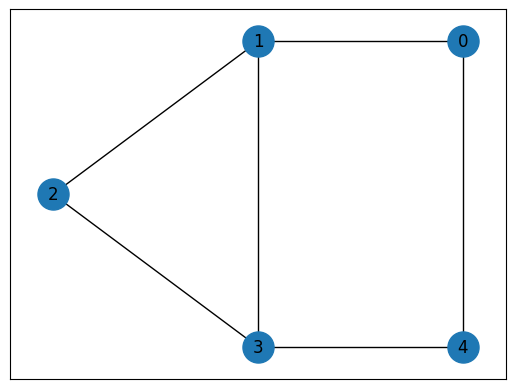

In [6]:
def maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem

def maxcut_instance():
    # Construct a simple graph for a MaxCut instance
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3, 4])
    G.add_edges_from([(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])
    E = [list(edge) for edge in G.edges]
    instance_data = {"V": G.number_of_nodes(), "E": E}
    pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
    nx.draw_networkx(G, pos, node_size=500)
    return instance_data

problem = maxcut_problem()
instance_data = maxcut_instance()
interpreter = jm.Interpreter(instance_data)
compiled_instance = interpreter.eval_problem(problem)

# Convert the compiled problem into a QAOA form.
qaoa_converter = qamomile.core.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode()

p = 5
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

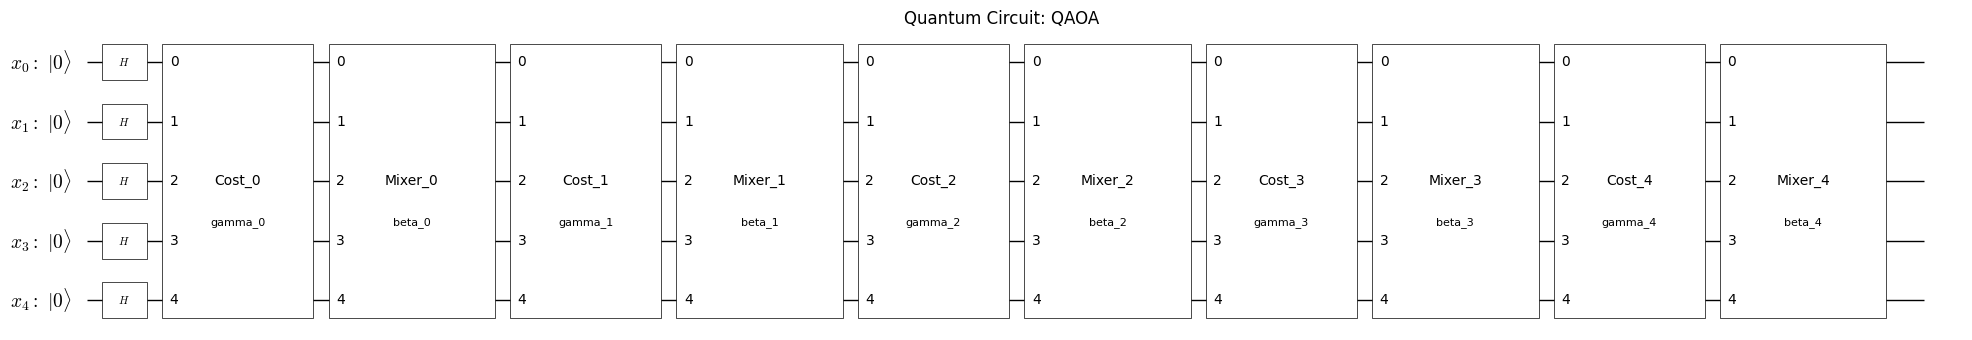

In [7]:
from qamomile.core.circuit.drawer import plot_quantum_circuit

plot_quantum_circuit(qaoa_circuit)

私たちは現在、MaxCut問題をQAOAのようなアルゴリズムに適したコストハミルトニアンに変換しました。パラメータ`p`は問題およびミキサーハミルトニアンの層数を決定します。各層のパラメータは変分可能であり、期待値を最小化するように調整され、理想的にはMaxCutインスタンスの良い解を導くことが期待されます。

## CUDA-QでのQAOA回路のトランスパイルと実行

QAOA回路とハミルトニアンが定義されたら、再びトランスパイラを使用し、今回はQAOA回路とコストハミルトニアンをCUDA-Q形式に変換します。

In [8]:
transpiler = CudaqTranspiler()
circ_func = transpiler.transpile_circuit(qaoa_circuit)
cudaq_hamiltonian = transpiler.transpile_hamiltonian(qaoa_hamiltonian)

cost_history = []

def objective(parameters):
    expectation_value = cudaq.observe(circ_func, cudaq_hamiltonian, parameters).expectation()
    cost_history.append(expectation_value)
    return expectation_value

ここで、`circ_func`はQAOAアンザッツから生成されたCUDA-Q回路関数です。`circuit(p)`を評価することで、与えられたパラメータ`p`に対するコストハミルトニアンの期待値が得られます。

## パラメータの最適化

最後に、CUDA-Qの最適化手法を用いてパラメータを更新し、より良い結果（例えば、MaxCut目的関数のコストが低いもの）をもたらすような値を探索します。

In [9]:
optimizer = cudaq.optimizers.COBYLA()
num_parameters = len(qaoa_circuit.get_parameters())
initial_parameters = np.random.uniform(-np.pi / 8, np.pi / 8, num_parameters)
optimizer.initial_parameters = initial_parameters
print("Initial parameters = ", optimizer.initial_parameters)

optimal_expectation, optimal_parameters = optimizer.optimize(dimensions=num_parameters, function=objective)
print("Optimal Parameters")
print(optimal_parameters)

Initial parameters =  [-0.3592987296348616, 0.013051261183044949, 0.32491744400253264, -0.12329265025548464, 0.1116984274445526, -0.34246869847233713, -0.23762749854446114, -0.04400424673470005, -0.04984738129914362, -0.35139414506470906]
Optimal Parameters
[1.6948217996605364, 2.288032487241756, 1.0916896164440923, 0.6461590151377731, 2.4531428322653945, -0.7121704374378344, 1.0619200346348785, 0.7242215081232152, -0.5623247703260246, -0.7761463348056767]


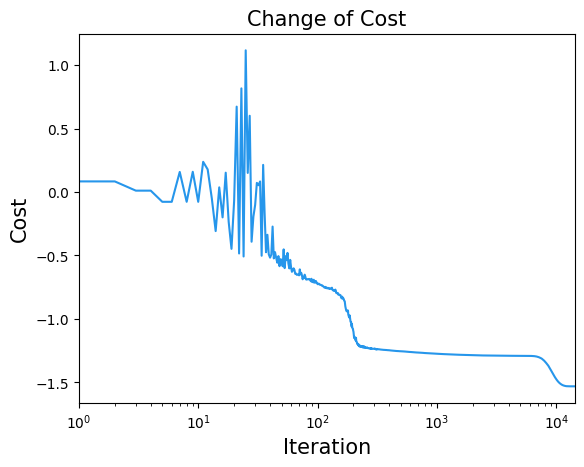

In [10]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, len(cost_history))
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

最適化されたパラメータが得られたら、`cudaq.sample`を使用してパラメータ化された量子回路からサンプルを取得し、回路の測定結果（カウント）を取得します。

In [12]:
results = cudaq.sample(circ_func, optimal_parameters, shots_count=1000)

## 結果の評価  
前に得られた `qaoa_counts`から、`qaoa_converter.decode`を使ってサンプルセットに変換することができます。このサンプルセットから実行可能な解のみを選択し、目的関数の値の分布を調べます。

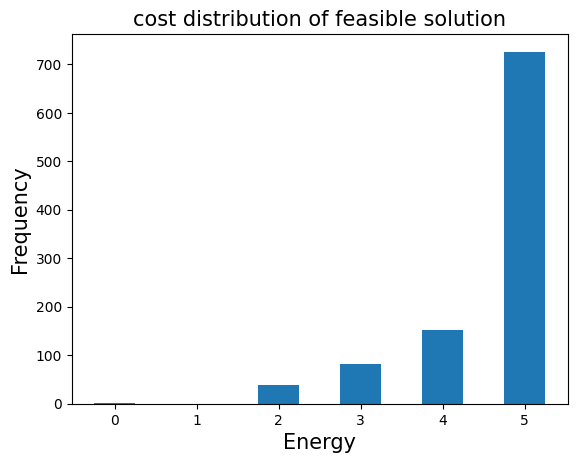

In [17]:
import matplotlib.pyplot as plt

sampleset = qaoa_converter.decode(transpiler, results)
feasible_ids = sampleset.summary.query("feasible == True").index
energies = []
frequencies = []

# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    if sample_id in feasible_ids:
        energy_freq[sample.objective] += 1

energies = list(energy_freq.keys())
frequencies = list(energy_freq.values())

plt.bar(energies, frequencies, width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()